In [8]:
import requests

In [9]:
standings_url="https://fbref.com/en/comps/9/2021-2022/2021-2022-Premier-League-Stats"


## Extract data of entire html

In [10]:
data=requests.get(standings_url)

'\n<!DOCTYPE html>\n<html data-version="klecko-" data-root="" lang="en" class="no-js" >\n<head id="suppress_all_ads">\n    <meta charset="utf-8">\n    <meta http-equiv="x-ua-compatible" content="ie=edge">\n    <meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=2.0" />\n\n    <title>Rate Limited Request (429 error) | Sports-Reference.com</title>\n\n    <link rel="canonical" href="https://www.sports-reference.com/429.html" />\n\n<!-- CSS start -->\n <style>body,html{color:#000;font:14px/1.25 Helvetica Neue,helvetica,arial,sans-serif;margin:0;padding:0}html:not(.backstop){scroll-behavior:smooth}html:not(.backstop) div,html:not(.backstop) span{scroll-snap-margin:2.5em 0 0 0;scroll-margin:2.5em 0 0 0}body{-webkit-text-size-adjust:none;-moz-text-size-adjust:none;-ms-text-size-adjust:none;background:#c9cbcd;position:relative;z-index:0}a img{border:0}li,ol,ul{list-style-type:none;margin:0;padding:0}table td,table th{border:0}iframe{max-width:100%}code{backgroun
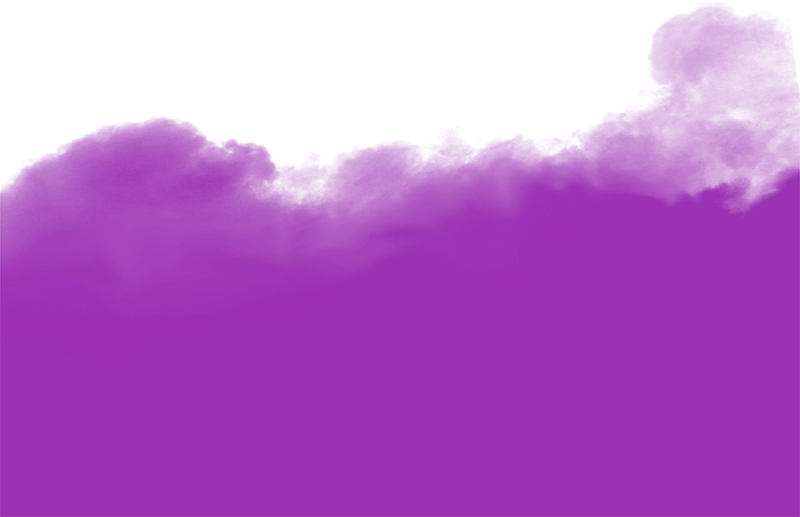

In [11]:
data.text

## Extract data of the table

In [12]:
from bs4 import BeautifulSoup

In [13]:
soup=BeautifulSoup(data.text)

In [14]:
standings_table = soup.select('table.stats_table')[0]


IndexError: list index out of range

In [ ]:
standings_table

## Extract all the links for the squad

In [ ]:
links=standings_table.find_all('a')

In [ ]:
links=[l.get("href")for l in links]

In [ ]:
links=[l for l in links if '/squads/' in l]

In [ ]:
team_urls=[f"https://fbref.com{l}"for l in links]

In [ ]:
team_urls

In [ ]:
team_url=team_urls[0]

In [ ]:
data=requests.get(team_url)

In [ ]:
pip install lxml

## Match a specific table-Scores & Fixtures

In [ ]:
import pandas as pd
matches=pd.read_html(data.text,match="Scores & Fixtures")

In [ ]:
matches[0]

## Extract shooting stats

In [ ]:
soup=BeautifulSoup(data.text)

In [ ]:
links=soup.find_all('a')

In [ ]:
links=[l.get("href") for l in links]

In [ ]:
links=[l for l in links if l and'all_comps/shooting/'in l]

In [ ]:
links

In [ ]:
data=requests.get(f"https://fbref.com{links[0]}")

## Match a specific table-Shooting

In [ ]:
shooting=pd.read_html(data.text,match="Shooting")[0]

In [ ]:
shooting.head()


## Single index level

In [ ]:
shooting.columns=shooting.columns.droplevel()

In [ ]:
shooting.head()

## Merge the two dataframes

In [ ]:
team_data=matches[0].merge(shooting[["Date","Sh","Dist","FK","PK","PKatt"]],on="Date")

In [ ]:
team_data.head()

In [ ]:
shooting.shape

## Scrap multiple years

In [ ]:
years = list(range(2022, 2020, -1))

In [ ]:
years

In [ ]:
all_matches=[]

In [ ]:
standings_url = "https://fbref.com/en/comps/9/2021-2022/2021-2022-Premier-League-Stats"

In [ ]:
import requests
import bs4
import pandas as pd
import time
for year in years:
    data = requests.get(standings_url)
    soup = BeautifulSoup(data.text)
    standings_table = soup.select('table.stats_table')[0]

    links = [l.get("href") for l in standings_table.find_all('a')]
    links = [l for l in links if '/squads/' in l]
    team_urls = [f"https://fbref.com{l}" for l in links]
    
    previous_season = soup.select("a.prev")[0].get("href")
    standings_url = f"https://fbref.com{previous_season}"
    
    for team_url in team_urls:
        team_name = team_url.split("/")[-1].replace("-Stats", "").replace("-", " ")
        data = requests.get(team_url)
        matches = pd.read_html(data.text, match="Scores & Fixtures")[0]
        soup = BeautifulSoup(data.text)
        links = [l.get("href") for l in soup.find_all('a')]
        links = [l for l in links if l and 'all_comps/shooting/' in l]
        data = requests.get(f"https://fbref.com{links[0]}")
        shooting = pd.read_html(data.text, match="Shooting")[0]
        shooting.columns = shooting.columns.droplevel()
        try:
            team_data = matches.merge(shooting[["Date", "Sh", "SoT", "Dist", "FK", "PK", "PKatt"]], on="Date")
        except ValueError:
            continue
        team_data = team_data[team_data["Comp"] == "Premier League"]
        
        team_data["Season"] = year
        team_data["Team"] = team_name
        all_matches.append(team_data)
        time.sleep(1)

In [ ]:
team_url.split("/")[-1].replace("-Stats","").replace("-"," ")

## Combine the data for all the teams

In [ ]:
match_df=pd.concat(all_matches)

In [ ]:
match_df

In [ ]:
match_df.columns=[c.lower() for c in match_df.columns]

In [ ]:
match_df.to_csv("matches.csv")